In [ ]:
!pip install -q transformers datasets evaluate accelerate pillow torchvision scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.5 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset
import seaborn as sns
dataset = load_dataset("garythung/trashnet")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

dataset-original.zip:   0%|          | 0.00/3.63G [00:00<?, ?B/s]

dataset-resized.zip:   0%|          | 0.00/42.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5054 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5054
    })
})

In [ ]:
import pandas as pd
labels = dataset['train']['label']
dataframe = pd.DataFrame(labels, columns=['labels'])

# Balance Between Classes Analysis

In [ ]:
from tqdm.notebook import tqdm
images_width = []
images_height = []
for i in tqdm(range(dataset['train'].num_rows)):
  image_size = dataset['train'][i]['image'].size
  images_height.append(image_size[0])
  images_width.append(image_size[1])

  0%|          | 0/5054 [00:00<?, ?it/s]

In [ ]:
dataframe['width'] = images_width
dataframe['height'] = images_height

<Axes: xlabel='labels'>

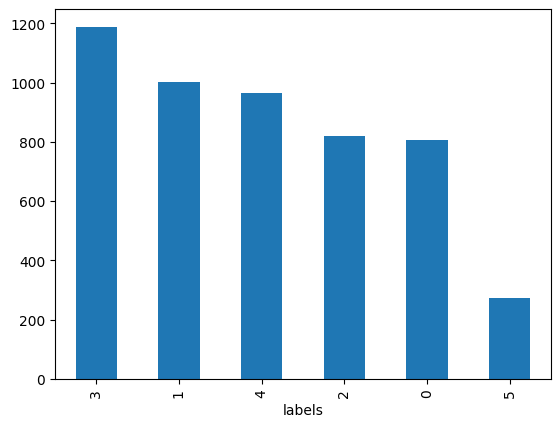

In [ ]:
dataframe.labels.value_counts().plot(kind='bar')

# Color & Size Distribution Analysis

In [ ]:
import numpy as np
image_red = []
image_green = []
image_blue = []
for i in tqdm(range(dataset['train'].num_rows)):
  image = dataset['train'][i]['image']
  image_array = np.array(image)
  image_R = image_array.copy()
  image_R[:, :, (1, 2)] = 0
  image_G = image_array.copy()
  image_G[:, :, (0, 2)] = 0
  image_B = image_array.copy()
  image_B[:, :, (0, 1)] = 0

  image_red.append(image_R.mean())
  image_green.append(image_G.mean())
  image_blue.append(image_B.mean())

  0%|          | 0/5054 [00:00<?, ?it/s]

In [ ]:
dataframe['red_channels_avg'] = image_red
dataframe['blue_channels_avg'] = image_blue
dataframe['green_channels_avg'] = image_green

In [ ]:
dataframe.describe()

,labels,width,height,red_channels_avg,blue_channels_avg,green_channels_avg
count,5054.000000,5054.000000,5054.000000,5054.000000,5054.000000,5054.000000
mean,2.261971,1935.832212,1943.370004,57.196971,51.401161,54.395853
std,1.501312,1597.154334,1483.555358,6.500522,9.174976,6.988708
min,0.000000,384.000000,512.000000,26.232379,17.854498,21.879618
25%,1.000000,384.000000,512.000000,54.360311,45.068810,50.265005
50%,2.000000,1416.000000,1480.000000,57.813197,52.919063,55.863051
75%,3.000000,3264.000000,3024.000000,61.221709,58.779129,59.046998
max,5.000000,4032.000000,4032.000000,75.941632,74.081441,74.413644


In [ ]:
dataframe.groupby(by='labels').agg({
    "width":"mean",
    "height":"mean",
    "red_channels_avg":"mean",
    "green_channels_avg":"mean",
    "blue_channels_avg":"mean",
})

,width,height,red_channels_avg,green_channels_avg,blue_channels_avg
labels,,,,,
0,1846.213400,1979.712159,56.683091,49.629930,42.631454
1,1982.035928,1865.197605,58.764572,56.859071,54.357843
2,1978.653659,1882.614634,54.923815,52.349437,50.623057
3,1991.878788,1980.727273,57.401031,54.850510,51.811880
4,1871.402490,1991.668050,57.002359,56.718130,56.311011
5,1886.014599,1972.262774,59.578806,55.390171,49.659567


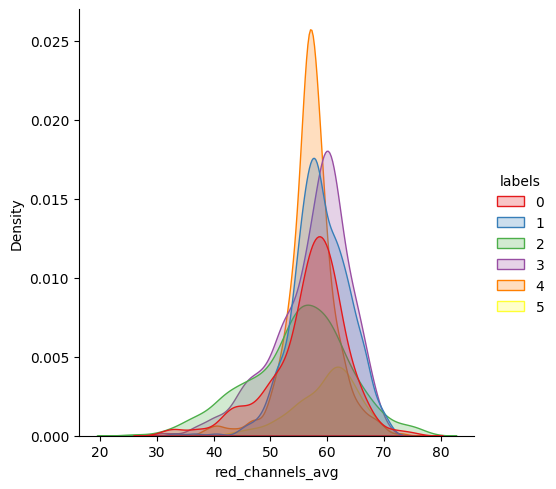

In [ ]:
sns.displot(dataframe, x="red_channels_avg", hue="labels", kind="kde", fill=True, palette="Set1")


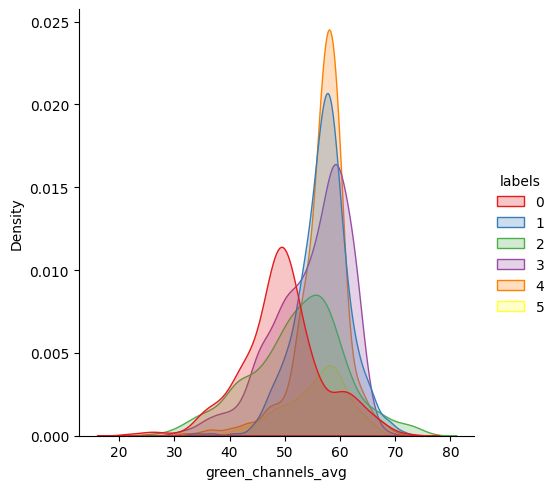

In [ ]:
sns.displot(dataframe, x="green_channels_avg", hue="labels", kind="kde", fill=True, palette="Set1")


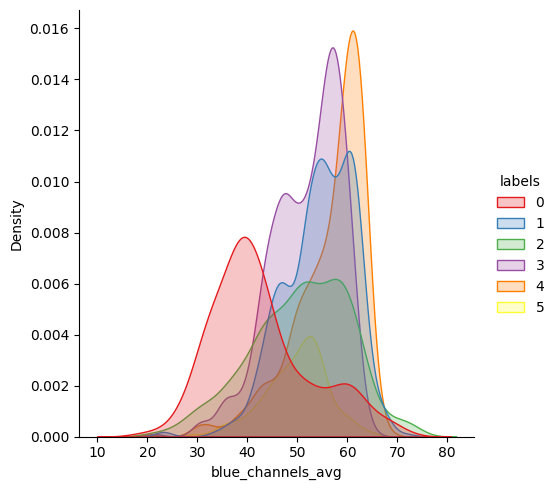

In [ ]:
sns.displot(dataframe, x="blue_channels_avg", hue="labels", kind="kde", fill=True, palette="Set1")


# Image Quality Analysis

In [ ]:
import skimage.metrics

In [ ]:
class_0 = dataframe[dataframe['labels'] == 0].copy()

In [ ]:
import cv2
import numpy as np

def assess_image_quality(image):
    """
    Assesses image quality based on sharpness, contrast, and noise levels.

    Args:
        image_path: Path to the image file.

    Returns:
        A dictionary containing quality metrics:
            - sharpness: Laplacian variance
            - contrast: Standard deviation of pixel intensities
            - noise: Variance of the Laplacian filtered image
    """

    # Sharpness: Calculate Laplacian variance
    img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    laplacian = cv2.Laplacian(img, cv2.CV_64F)
    sharpness = np.var(laplacian)

    # Contrast: Calculate standard deviation of pixel intensities
    contrast = np.std(img)

    # Noise: Calculate variance of Laplacian filtered image
    noise = np.var(laplacian)

    return {'sharpness': sharpness, 'contrast': contrast, 'noise': noise}

In [ ]:
sharpnesses = []
contrasts = []
noises = []

In [ ]:
for i in tqdm(range(dataset['train'].num_rows)):
  image_quality = assess_image_quality(dataset['train'][i]['image'])

  sharpnesses.append(image_quality["sharpness"])
  contrasts.append(image_quality["contrast"])
  noises.append(image_quality["noise"])

  0%|          | 0/5054 [00:00<?, ?it/s]

In [ ]:
dataframe['sharpness'] = sharpnesses
dataframe['contrast'] = contrasts
dataframe['noise'] = noises

In [ ]:
dataframe.groupby(by='labels').agg({
    "sharpness":"mean",
    "contrast":"mean",
    "noise":"mean",
})

,sharpness,contrast,noise
labels,,,
0,139.620864,52.200880,139.620864
1,103.085439,50.305759,103.085439
2,226.977106,57.638609,226.977106
3,365.533097,50.566535,365.533097
4,141.055949,40.335585,141.055949
5,123.479919,46.905919,123.479919


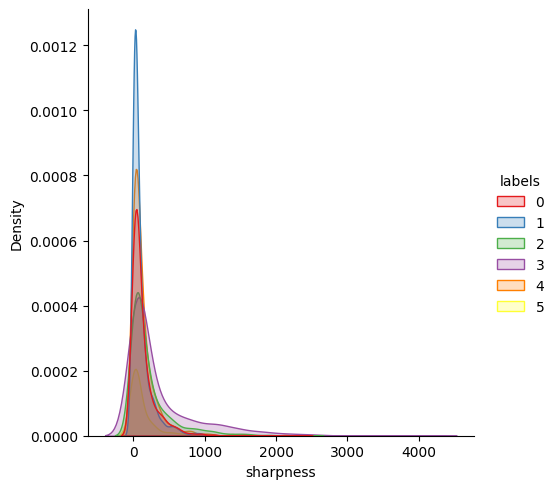

In [ ]:
sns.displot(dataframe, x="sharpness", hue="labels", kind="kde", fill=True, palette="Set1")


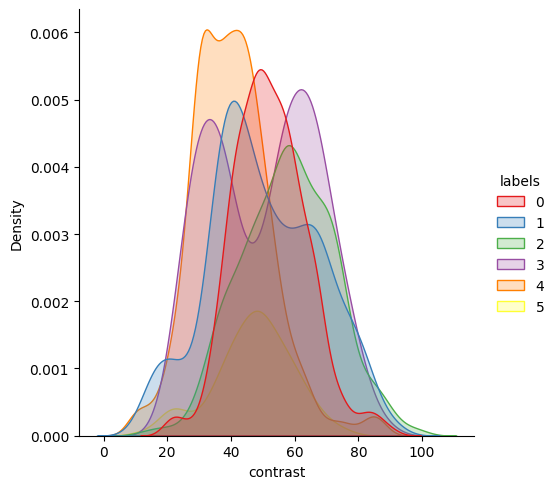

In [ ]:
sns.displot(dataframe, x="contrast", hue="labels", kind="kde", fill=True, palette="Set1")


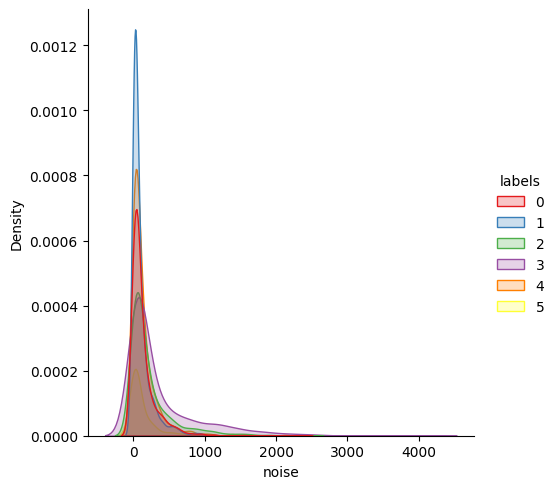

In [ ]:
sns.displot(dataframe, x="noise", hue="labels", kind="kde", fill=True, palette="Set1")


# Insights

- the dataset only contain 5054 samples with imbalance classes especially class 5.
- The image sizes vary, but the average size of each class is not much different.
- In the distribution of channel values, there are also no significant differences in each class except class 0 in green and blue channels.
- Each class has the same sharpness and noise, but for contrast almost every class has a different average value.

From the points above it can be concluded that in terms of the three colors and sizes of each class there are no significant differences, so the model that is suitable for this dataset is a model that is able to efficiently learn line and angle patterns from images. The dataset also only has a sample size of 5054 with an unbalanced nature, this is also a special concern when choosing a model.